In [71]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import CoherenceModel
import gensim.corpora as corpora

# Read in Dataset

In [118]:
df = pd.read_csv('../data/curated/reviews/yiting_cleaned_reviews.csv')
df

,Sentiment,Time,Text,processed_text
0,0,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,0,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,0,18/6/21,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,0,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,0,1/7/21,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...
...,...,...,...,...
5439,1,26/2/21,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...
5440,1,18/12/19,It looks llike I just walked into a raw deal. ...,look llike walked raw deal item intolerably st...
5441,1,19/1/20,Thank god that i tasted the metal before i swa...,thank god taste metal swallow dont even get ge...
5442,1,13/9/20,This product was very good when I began buying...,product good begin buy lately terrible taste r...


# TF-IDF

In [123]:
vectorizer = TfidfVectorizer(lowercase=True,
                             analyzer='word',
                             stop_words = 'english',
                             ngram_range = (1,1),
                             min_df = 3)
vectorized_text = vectorizer.fit_transform(df['processed_text'])

In [124]:
vectorized_text.shape

(5444, 3949)

In [125]:
vectorizer.get_feature_names_out()

array(['ability', 'able', 'absolute', ..., 'ziplock', 'zippy', 'zucchini'],
      dtype=object)

# LDA

In [152]:
#Coherance Score function 
#The higher the better. Input: Sklearn Model, output: Coherance score

def get_Cv(model, df_columnm):
  topics = model.components_
  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_columnm]
  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix
  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]
  feature_names = [dictionary[i] for i in range(len(dictionary))]
  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [133]:
#Finding the right number of topis (n_components)

cv_scores = []
lg_scores = []
perp_scores = []

for i in range(1,11):
    lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
 n_components=i, n_jobs=-1, perp_tol=0.1,
 random_state=20, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

    lda_topics = lda_model.fit_transform(vectorized_text)
    
    cv_scores.append(get_Cv(lda_model,df['processed_text']))
    lg_scores.append(lda_model.score(vectorized_text))
    perp_scores.append(lda_model.perplexity(vectorized_text))
    # See model parameters
    #print(lda_model.get_params())

Coherance Score:  0.747241345113341
Log Likelihood:  -166278.72847467771
Perplexity:  1891.0078048030143
Coherance Score:  0.7331917071185434
Log Likelihood:  -172168.69196138403
Perplexity:  2470.364900840852
Coherance Score:  0.7290572750503688
Log Likelihood:  -177038.29117213117
Perplexity:  3081.2119095699863
Coherance Score:  0.7424624448295551
Log Likelihood:  -180596.68392968338
Perplexity:  3621.1236599454624
Coherance Score:  0.7235204905192512
Log Likelihood:  -182218.9697241557
Perplexity:  3897.733715458449
Coherance Score:  0.7031051587500845
Log Likelihood:  -184011.5712611755
Perplexity:  4228.021842807344
Coherance Score:  0.7314644003553329
Log Likelihood:  -185649.08518905638
Perplexity:  4554.137281727133
Coherance Score:  0.7165408452755669
Log Likelihood:  -188520.4207198949
Perplexity:  5187.8658467705945
Coherance Score:  0.7075378716455663
Log Likelihood:  -188038.15769549346
Perplexity:  5075.574985480946
Coherance Score:  0.719073240131727
Log Likelihood:  -1

Text(0, 0.5, 'Perplexity')

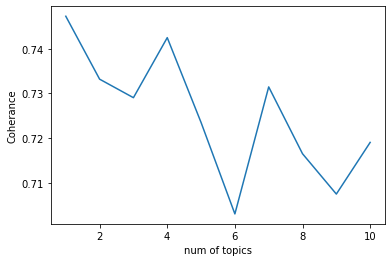

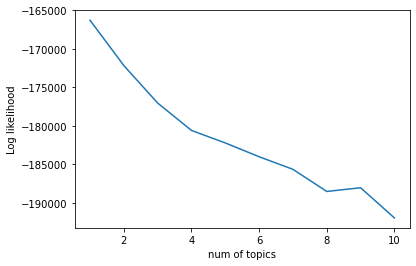

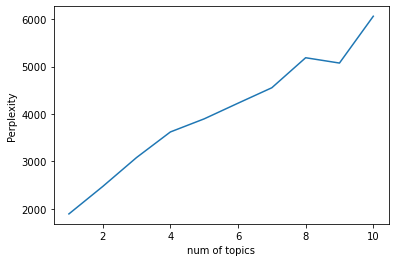

In [143]:
x = np.array(range(1,11))
plt.plot(x,cv_scores)
plt.xlabel("num of topics")
plt.ylabel("Coherance")
plt.figure()
plt.plot(x,lg_scores) 
plt.xlabel("num of topics")
plt.ylabel("Log likelihood")
plt.figure()
plt.plot(x,perp_scores)
plt.xlabel("num of topics")
plt.ylabel("Perplexity") 

In [154]:
# lda component: for each topic, the prob of each word in the vocabulary
lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
 n_components=4, n_jobs=-1, perp_tol=0.1,
 random_state=20, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

lda_topics = lda_model.fit_transform(vectorized_text)
lda_model.components_.shape

(4, 3949)

In [163]:
vocab = vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse = True)[:100]
    print("Topic " + str(i) + ": ")
    print(" ".join([i[0] for i in sorted_words]))

Topic 0: 
butter peanut cake gluten popcorn gift noodle pasta bread free great love rice pancake oil wheat easy make flour taste use olive best maple mix price cheese good white toast gf product family sandwich son sauce school fast guest service mother dairy spread dress salad affordable gravy enjoy sent birthday dish sister egg daughter kid recipe quick pamela customer door asian stock grinder pb convenience biscuit allergic delicious bake prepare buy mart bisquick cook movie amazon sam beat jam salsa house work rum ramen grill reasonably pan machine law email coconut celiac anymore yummy fantastic auto soup really texture wal
Topic 1: 
product taste great good like buy love price flavor make order food eat use amazon bag really store time try snack box purchase chip tasty little bar better pack think come salt healthy package say best item quality look year way add know brand local sweet treat sugar fresh free lot ingredient want day recommend hard chocolate bit grocery cooky calori

In [155]:
dominant_topic_list = [np.where(topic == np.max(topic))[0][0] for topic in lda_topics]
df['dominant_topic'] = dominant_topic_list
df

,Sentiment,Time,Text,processed_text,dominant_topic
0,0,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...,2
1,0,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...,1
2,0,18/6/21,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...,1
3,0,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...,1
4,0,1/7/21,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...,1
...,...,...,...,...,...
5439,1,26/2/21,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...,1
5440,1,18/12/19,It looks llike I just walked into a raw deal. ...,look llike walked raw deal item intolerably st...,1
5441,1,19/1/20,Thank god that i tasted the metal before i swa...,thank god taste metal swallow dont even get ge...,1
5442,1,13/9/20,This product was very good when I began buying...,product good begin buy lately terrible taste r...,1


In [156]:
df.dominant_topic.value_counts().sort_index()

0     212
1    3998
2      24
3    1210
Name: dominant_topic, dtype: int64

In [160]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [1,2,3,4,5], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(vectorized_text)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0), n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1, param_grid={'learning_decay': [0.5, 0.7, 0.9]},
             return_train_score='warn')

In [161]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_text))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 1}
Best Log Likelihood Score:  -36195.64129151554
Model Perplexity:  1890.0796887448364


# Model for Topic Modelling

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(lda_topics, df['dominant_topic'], test_size = 0.2, random_state = 1)

In [18]:
pd.DataFrame(y_train).value_counts()

dominant_topic
2                 2632
1                 1214
0                  340
3                  169
dtype: int64

In [19]:
svc = SVC(C=1.0, random_state=1, kernel='poly')

In [20]:
svc.fit(x_train, y_train)

SVC(kernel='poly', random_state=1)

In [21]:
x_test_predicted = svc.predict(x_test)

In [22]:
np.sum(x_test_predicted == y_test)

1079

In [23]:
np.sum(x_test_predicted == y_test)/y_test.shape[0]

0.9908172635445363